# Preprocessing

Some preprocessing steps.

But not the ones mentioned by Patrick Rockenschaub's paper.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

%load_ext autoreload
%autoreload 2

---
## Setting dtype of time and `float32`
The dtype of the 'time' column is automatically set to `Timedelta`.  
Hence, when loading DataFrame and converting it to numpy, the numpy array will not have a single dtype. Instead the numpy array will be of dtype 'object'.  
This can create many complications. Therefore, we change it to float.

In addition, using `float32` over `float64` is memory saving and the precision is good enough. So changing the dtypes to `float32` for all other dtypes. This includes `int32` for the id column and `bool`for the label column. Parquet is able in preserving the dtype, as it is a binary format (CSV format cannot preserve dtype).


In [11]:
# path to data
miiv_path_p = '~/Documents/data/ts/miiv/fully_observed/miiv_ts_wide.parquet'
# read in data
df = pd.read_parquet(miiv_path_p)
# change dtype of time column
# df['time'] = df['time'].apply(lambda x: x.total_seconds() / 60 / 60)
# change all float64 dtypes to float 32
# float64_columns = df.select_dtypes(include='float64').columns
# df[float64_columns] = df[float64_columns].astype('float32')
df = df.astype('float32')
# save data
df.to_parquet(miiv_path_p)
print(df.shape)
df.head()

(3552209, 51)


,id,time,label,alb,alp,alt,ast,be,bicar,bili,...,phos,plt,po2,ptt,resp,sbp,temp,tnt,urine,wbc
0,30000152.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,14.0,124.5,36.000000,NaN,280.0,NaN
1,30000152.0,1.0,0.0,NaN,NaN,NaN,NaN,-3.0,NaN,NaN,...,NaN,NaN,242.0,NaN,16.0,141.0,37.277779,NaN,45.0,NaN
2,30000152.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN
3,30000152.0,3.0,0.0,NaN,NaN,NaN,NaN,-4.0,19.0,NaN,...,3.1,173.0,215.0,25.299999,14.0,116.0,37.500000,NaN,50.0,17.0
4,30000152.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,20.0,111.0,NaN,NaN,45.0,NaN


Run this code to do the final preprocessing steps for the data provided by Patrick.  
This includes getting the correct dtypes and applying z-score to selected columns.

In [4]:
path_original_data = Path('~/Documents/data/ts/miiv_old/fully_observed/dyn.parquet') # contains dynamic information
# path_preprocessed_data = Path('~/Documents/data/ts/miiv/fully_observed/miiv_ts_wide.parquet') # path where to save
# path_preprocessed_data = Path('~/Documents/data/ts/miiv/MCAR_1/miiv_MCAR_1_ts_wide.parquet') # path where to save
path_preprocessed_data = Path('~/Documents/data/ts/miiv_test/MCAR_1/miiv_test_MCAR_1_ts_wide.parquet') # path where to save
path_outcome = '~/Documents/data/ts/miiv_old/fully_observed/outc.parquet' # contains information about sepsis label

# load dynamic data
df = pd.read_parquet(path_original_data)
print('shape:', df.shape)
print('Num unique ids:', pd.unique(df['stay_id']).shape)
print('--- Transformed ---')

# rename stay_id column to id
df = df.rename(columns={'stay_id': 'id'})

# load outcome data (sepsis label)
df_outc = pd.read_parquet(path=path_outcome)
df_outc = df_outc.rename(columns={'stay_id':'id'})

# combine dynamic and outcome data
combined = pd.merge(df_outc, df, on=['id', 'time'], how='left')
df = combined

# change time column to int32
df['time'] = df['time'].apply(lambda x: x.total_seconds() / 60 / 60).astype('int32')

# change all float64 dtypes to float 32
float64_columns = df.select_dtypes(include='float64').columns
df[float64_columns] = df[float64_columns].astype('float32')

only_first_100_ids = False
# Activate this block to create a small version of mimic
if only_first_100_ids:
    # Get the first 100 unique IDs
    unique_ids = df['id'].unique()[:100]
    # Filter the DataFrame to only contain rows with the first 100 unique IDs
    df = df[df['id'].isin(unique_ids)]

# # change label (bool) to float32
# df['label'] = df['label'].astype('float32')

# perform z-score 
labels_to_normalize = df.columns[3:]   # excluding columns: id, time, label
means = df[labels_to_normalize].mean(skipna=True)
std = df[labels_to_normalize].std(skipna=True, ddof=0)
df[labels_to_normalize] = (df[labels_to_normalize] - means) / std
# normalize time
df['time'] = df['time'] / 100

# save data
df.to_parquet(path_preprocessed_data, index=False)

print('shape:', df.shape)
print('Num unique ids:', pd.unique(df['id']).shape)
print(df.dtypes)
df.head()

shape: (3552209, 50)
Num unique ids: (67056,)
--- Transformed ---
shape: (5067, 51)
Num unique ids: (100,)
id            int32
time        float64
label          bool
alb         float32
alp         float32
alt         float32
ast         float32
be          float32
bicar       float32
bili        float32
bili_dir    float32
bnd         float32
bun         float32
ca          float32
cai         float32
ck          float32
ckmb        float32
cl          float32
crea        float32
crp         float32
dbp         float32
fgn         float32
fio2        float32
glu         float32
hgb         float32
hr          float32
inr_pt      float32
k           float32
lact        float32
lymph       float32
map         float32
mch         float32
mchc        float32
mcv         float32
methb       float32
mg          float32
na          float32
neut        float32
o2sat       float32
pco2        float32
ph          float32
phos        float32
plt         float32
po2         float32
ptt         f

/tmp/ipykernel_1531964/1834172371.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[labels_to_normalize] = (df[labels_to_normalize] - means) / std
/tmp/ipykernel_1531964/1834172371.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = df['time'] / 100


,id,time,label,alb,alp,alt,ast,be,bicar,bili,...,phos,plt,po2,ptt,resp,sbp,temp,tnt,urine,wbc
0,30000153,0.00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.918620,0.118068,-1.715490,NaN,0.897718,NaN
1,30000153,0.01,False,NaN,NaN,NaN,NaN,-0.503402,NaN,NaN,...,NaN,NaN,0.844780,NaN,-0.525466,0.909291,0.630508,NaN,-0.625437,NaN
2,30000153,0.02,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.593030,NaN
3,30000153,0.03,False,NaN,NaN,NaN,NaN,-0.780138,-1.070249,NaN,...,-0.463437,-0.111949,0.571519,-0.663711,-0.918620,-0.289532,1.038506,NaN,-0.593030,1.125449
4,30000153,0.04,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.260843,-0.529297,NaN,NaN,-0.625437,NaN


# Check if z-score worked

Let us have a look at the histogram for each variable.

Also let us have a look if the mean and std. dev are 0 and 1, respectively

In [4]:
# path_preprocessed_data = Path('~/Documents/data/ts/miiv_test/MCAR_1/miiv_test_MCAR_1_ts_wide.parquet')
df = pd.read_parquet(path_preprocessed_data)


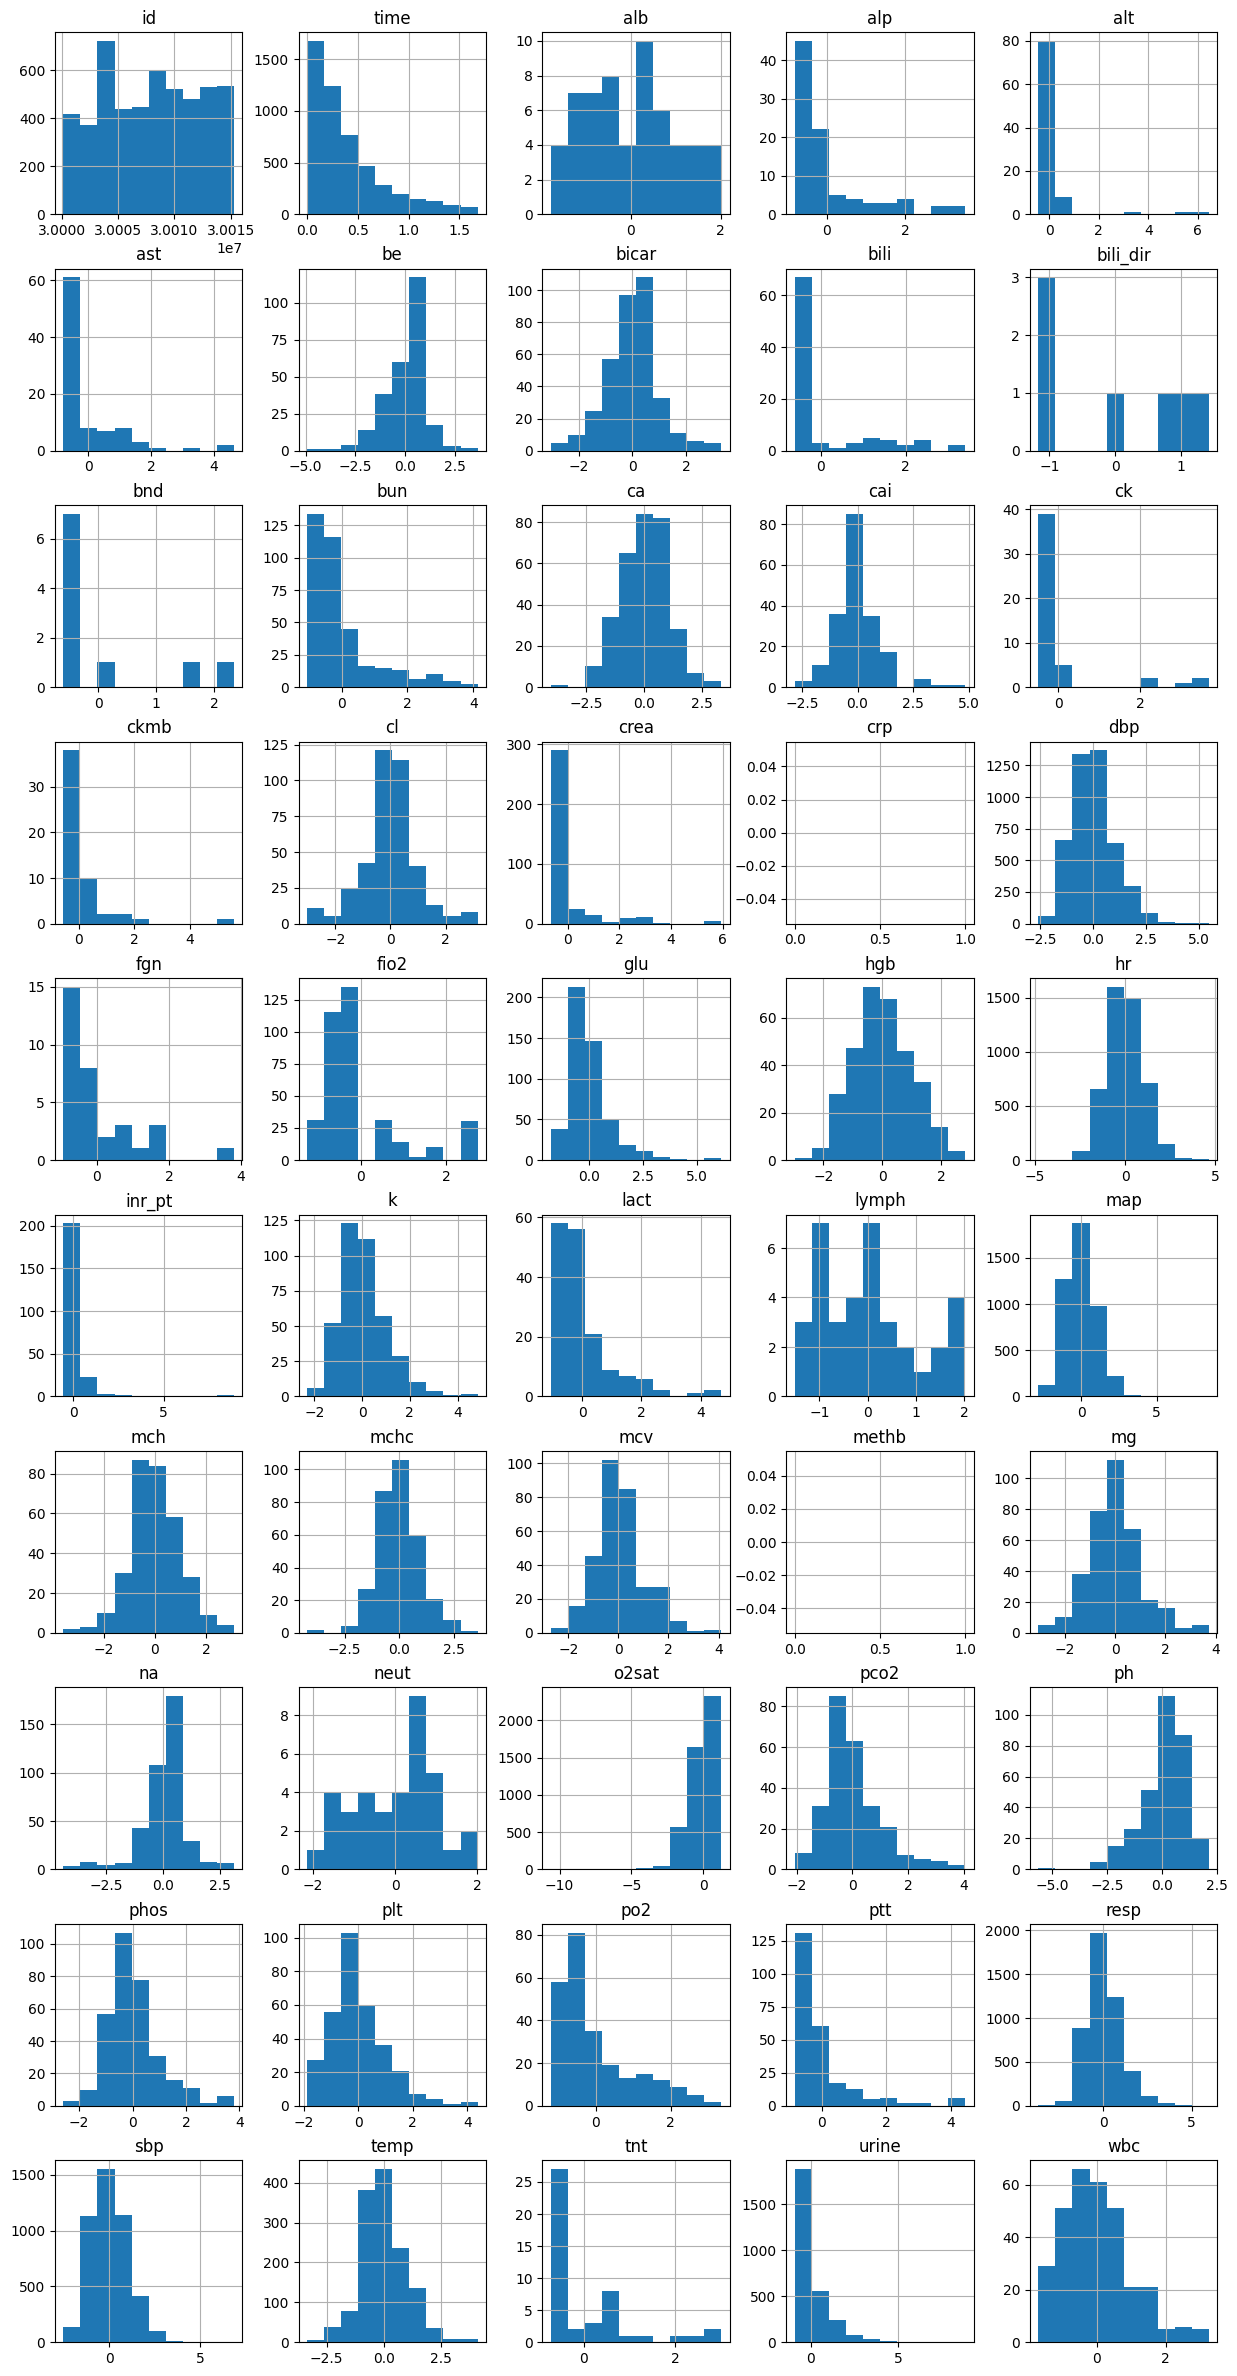

In [12]:
_ = df.hist(figsize=(15, 30), layout=(10,5))

In [14]:
df.mean()

id          3.000796e+07
time        3.892579e-01
label       1.539372e-02
alb         0.000000e+00
alp         3.178915e-08
alt         1.047994e-08
ast         4.715972e-08
be          7.421590e-09
bicar      -9.616884e-08
bili        0.000000e+00
bili_dir    6.811960e-08
bnd         0.000000e+00
bun         2.371013e-08
ca          1.151091e-06
cai        -3.038910e-07
ck          9.731370e-09
ckmb       -8.830318e-09
cl         -3.365179e-07
crea       -2.137085e-08
crp                  NaN
dbp         8.522559e-08
fgn         4.334883e-08
fio2        6.478766e-08
glu         8.275686e-08
hgb         1.793745e-08
hr          7.014979e-08
inr_pt     -4.890638e-08
k          -2.047028e-07
lact       -2.354751e-08
lymph       3.973643e-08
map         2.474215e-07
mch        -1.453218e-06
mchc        1.332117e-07
mcv        -3.390842e-07
methb                NaN
mg         -5.357721e-07
na          1.141519e-06
neut       -3.178914e-07
o2sat      -8.009123e-07
pco2        2.152261e-07


In [15]:
df.std()

id          4223.081346
time           0.363509
label          0.123125
alb            1.008734
alp            1.005602
alt            1.005540
ast            1.005540
be             1.001951
bicar          1.001403
bili           1.005540
bili_dir       1.080123
bnd            1.054093
bun            1.001384
ca             1.001596
cai            1.002601
ck             1.010363
ckmb           1.009390
cl             1.001305
crea           1.001404
crp                 NaN
dbp            1.000112
fgn            1.015505
fio2           1.001361
glu            1.001035
hgb            1.001571
hr             1.000106
inr_pt         1.002144
k              1.001265
lact           1.003101
lymph          1.014185
map            1.000111
mch            1.001591
mchc           1.001591
mcv            1.001591
methb               NaN
mg             1.001408
na             1.001265
neut           1.014185
o2sat          1.000109
pco2           1.001951
ph             1.001581
phos           1